# Working example
In this section we explore some of the capabilities of the engine. We will begin by selecting a node in the Tree of Life that represents the family of mosquitoes (Family *Cullicidae*). This node is related to Genus and Order nodes and has direct arrow to Occurrence nodes which include information of location and time where the record was found. We will explore these nodes and extract the cell type nodes. Each cell node has links to other neighbouring cell nodes. 
We will explore this structure to obtain local Tree of Life for each cell using a neighborhood size of 5 (order 5). 
The resulting trees will be collapsed to represent a 'regional'(global) tree. We will *trim* the resulting tree to only include groups of animals that could potentially be bitten by mosquitos (i.e. Mammals, birds, reptiles and frogs). We will use this subtree to rank the nodes that are more frequent, this to have an estimate of which nodes are co-occurring more often with mosquitos in general.
Methods for visualization of the network and spatial patterns are also showed.

## Obtaining and runing the engine
As explained in section (?) the engine is composed of three modules. These modules can be downloaded and run as docker containers.
* [Graph Storage and Processing Unit ](https://hub.docker.com/r/molgor/postgis_biospytial)
* [Biospytial Computing Engine](https://hub.docker.com/r/molgor/biospytial)
* [Relational Geoprocessing Unit](https://hub.docker.com/r/molgor/neo4j_biospytial)

The source code can be downloaded from [here](https://github.com/molgor/biospytial)

>> Note for reviewers:
At the moment the source code is a private repository. The containers are public.


<img src="../biospytial.png" alt="Drawing" style="width: 500px;"/>

In [1]:
## Import modules and libraries
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import numpy as np
import matplotlib.pyplot as plt

<img src="mosquito2.jpg" alt="Drawing" style="width: 500px;"/>

## Selecting the *Mosquito* node
Mosquitos are members of the family *Culicidae*. 
For starting the traversal we will need to first select this node.
For doing this we will use the function 'pickNode'.
Using the following syntaxis:
    
```python
pickNode(<Type of node>,'name of the node')
```

We would need to load the 'pickNode' and node class 'Family'


In [2]:
from drivers.graph_models import Order, Family, graph, pickNode
mosquitos = pickNode(Family,"Culicidae")

*mosquitos* is now an instance of the class **Family**. As such, it has associated attributes and methods.
string representation is the following:

In [3]:
dir(mosquitos)

['_GraphObject__ogm',
 '__class__',
 '__db_create__',
 '__db_delete__',
 '__db_merge__',
 '__db_pull__',
 '__db_push__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__eq__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__ne__',
 '__new__',
 '__ogm__',
 '__primarykey__',
 '__primarylabel__',
 '__primaryvalue__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_isClass',
 '_isFamily',
 '_isGenus',
 '_isKingdom',
 '_isOccurrence',
 '_isOrder',
 '_isPhylum',
 '_isRoot',
 '_isSpecie',
 'abundance',
 'allOccurrences',
 'cells',
 'children',
 'children_link',
 'getAncestors',
 'getAssociatedTrees',
 'getCellsById',
 'getParent',
 'getSiblings',
 'getUpperScaleCells',
 'giveNCells',
 'has_events',
 'id',
 'insideCellRatio',
 'is_in',
 'keyword',
 'level',
 'levelname',
 'localoccurrences',
 'mergeLinageWithNode',
 'name',
 'parent_link',
 'propagateCells',
 'select',
 'setLabel',
 '

We will proceed to traverse through all the cells where an occurrence of a mosquito (member of family *Culicidae*) has been found. For doing this we will call the attribute *cells*. This attribute is abstracted as *lazy evaluation*. Therefore, for fetching all the associated data we need to cast the object into a list (or partial list using an iterator). The *time* features shows how much time it took to extract this information.

In [4]:
%time cells = list(mosquitos.cells)
print("cells has %s elements"%len(cells))

CPU times: user 856 ms, sys: 24 ms, total: 880 ms
Wall time: 1.04 s
cells has 10 elements


The resulting list has cell instances. Each one connected to other cells by the relation *IS_NEIGHBOUR_OF*. 
We can access these related cells with the method *getNeighbours()*.

In [5]:
neighbours = map(lambda cell : cell.getNeighbours(with_center=True),cells)

#### Optional step
The resulting list may not be to big enough, we would need to expand this neighbourhood some higher order (say 5).
To do this we can merge all the list of neighbours into one single list of cells and removing any repetition iteratively.

In [6]:
degree = 3
for i in range(degree):
    ## flatten all the list of neighbours into a single list
    neighbours = reduce(lambda a,b : a+b ,neighbours)
    ## Remove repetitions
    neighbours = list(set(neighbours))
    neighbours = map(lambda cell : cell.getNeighbours(with_center=True),neighbours)
## post process result
neighbours = reduce(lambda a,b : a+b,neighbours)
neighbours = list(set(neighbours))


The resulting *neighbours* list has now 284 Cell nodes. In our current implementation the name of the Grid (where all the Cells are contained is called *mex4km*).
We can display the first 3 elements as this:

In [7]:
neighbours[:3]

[< Cell-mex4km id = 236040 >,
 < Cell-mex4km id = 233773 >,
 < Cell-mex4km id = 233772 >]

## Converting cells to local taxonomic trees
We can obtain the Tree of Life inside each Cell node by only extracting the occurrences inside each cell (using the method 'occurrencesHere') and pluging them into the *TreeNeo* constructor. The name *TreeNeo* comes because it is using the Neo4j graph storage backend. 

In [8]:
from drivers.tree_builder import TreeNeo
cell_1 = neighbours[1]
tree_1 = TreeNeo(cell_1.occurrencesHere())

In this case, cell_1 has no associated occurrences. i.e

tree_1 :: <LocalTree Of Life | No record available: - n.count : 0- >

We can generate all the trees of the neighbouring cells like this:

In [9]:
%time sample_trees = map(lambda cell : TreeNeo(cell.occurrencesHere()),neighbours)

CPU times: user 4min 8s, sys: 7.8 s, total: 4min 16s
Wall time: 4min 36s


'sample_trees' is a list of Trees. We can display the first elements as before. The 'n.count' value indicates the number of total occurrences.

In [10]:
sample_trees[:4]

[<LocalTree Of Life | Root: LUCA - n.count : 514- >,
 <LocalTree Of Life | Root: LUCA - n.count : 137- >,
 <LocalTree Of Life | Root: LUCA - n.count : 44- >,
 <LocalTree Of Life | Root: LUCA - n.count : 9- >]

In this case the first three elements are empty trees (no records) , the last one has 137 occurrences.
## Exploratory analysis on a single Tree
We will select the last tree in the example before to account for informative data.

In [11]:
tree = sample_trees[4]

The object 'tree' wraps the entire tree structure. All 'Tree' objects has as starting node the Root of the Taxonomic Tree. This represents all known life. 

In [12]:
root = tree.node
print(root)

<LocalTree | Root: LUCA - n.count : 0- | AF: 0.05 >


Root node is similar to Family node, Genus node, etc, they all belong to the TreeNode class. 

We can access a specific type of child node with the prefix 'to_'.  
For example, accessing the node 'Animalia' can be done with: 

In [13]:
animalia = root.to_Animalia
print(animalia)

<LocalTree | Kingdom: Animalia - n.count : 115- | AF: 0.05 >


We can concatenate this methods as long as the children attribute is not empty.
>> Hint: If we are using Biospytial in an interactive session (like the current notebook) we can use the key [TAB] to autocomplete and show the available nodes.

In [14]:
root.to_Animalia.to_Arthropoda.to_Insecta.to_Hemiptera.to_Pentatomidae.to_Euschistus

<LocalTree | Genus: Euschistus - n.count : 1- | AF: 0.05 >

The resulting node (animalia) is again of a 'TreeNode' type. 
By recursion, we can explore this node until we reach no children.

We can also explore the Tree by taxonomic level

In [15]:
tree.phyla

[<LocalTree | Phylum: Chordata - n.count : 111- | AF: 0.05 >,
 <LocalTree | Phylum: Arthropoda - n.count : 4- | AF: 0.05 >,
 <LocalTree | Phylum: Magnoliophyta - n.count : 3- | AF: 0.05 >]

In [16]:
tree.genera

[<LocalTree | Genus: Albizia - n.count : 2- | AF: 0.05 >,
 <LocalTree | Genus: Eleutherodactylus - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Plebeia - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Sceloporus - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Norops - n.count : 16- | AF: 0.05 >,
 <LocalTree | Genus: Ameiva - n.count : 5- | AF: 0.05 >,
 <LocalTree | Genus: Calocitta - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Chlorostilbon - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Archilochus - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Amazilia - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Tyrannus - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Dalbergia - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Coniophanes - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Quiscalus - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Icterus - n.count : 1- | AF: 0.05 >,
 <LocalTree | Genus: Incilius - n.count : 19- | AF: 0.05 >,
 <LocalTree | Genus: Rhinella - n.co

## Tree operations
Tree objects allow algebraic operations. These operations include:

* union (+)
* intersection (&)
* difference (-)

The operations are equivalent to corresponding Set operations acting at the occurrence level. 

For the purpose of this example, 
Let t1 and t2 two trees from the list of 'sampled trees'
#### Let

In [17]:
t1 = sample_trees[4]
t2 = sample_trees[5]

### Sum (union)
Suming two trees is equivalent to merge them

In [18]:
t3 = t1 + t2 

INFO Merging Trees


For example the classes of t1 and t2 are:

In [19]:
t1.classes

[<LocalTree | Class: Amphibia - n.count : 69- | AF: 0.05 >,
 <LocalTree | Class: Aves - n.count : 15- | AF: 0.05 >,
 <LocalTree | Class: Reptilia - n.count : 26- | AF: 0.05 >,
 <LocalTree | Class: Mammalia - n.count : 1- | AF: 0.05 >,
 <LocalTree | Class: Magnoliopsida - n.count : 3- | AF: 0.05 >,
 <LocalTree | Class: Insecta - n.count : 4- | AF: 0.05 >]

In [20]:
t2.classes

[<LocalTree | Class: Aves - n.count : 18- | AF: 0.05 >,
 <LocalTree | Class: Magnoliopsida - n.count : 20- | AF: 0.05 >]

In [21]:
t3.classes

[<LocalTree | Class: Amphibia - n.count : 69- | AF: 0.05 >,
 <LocalTree | Class: Aves - n.count : 33- | AF: 0.05 >,
 <LocalTree | Class: Reptilia - n.count : 26- | AF: 0.05 >,
 <LocalTree | Class: Mammalia - n.count : 1- | AF: 0.05 >,
 <LocalTree | Class: Magnoliopsida - n.count : 23- | AF: 0.05 >,
 <LocalTree | Class: Insecta - n.count : 4- | AF: 0.05 >]

### Intersection
Selecting the intersection is done through the '&' operation.
The intersection occurs at the occurrence nodes.
In this case the intersection is empty because the Occurrences are disjoint cells. 

In [22]:
t = t1 & t2
print(t)

<LocalTree Of Life | No record available: - n.count : 0- >


### Difference
Taking the difference of two trees is equivalent to select the nodes that are in one tree but not the other.
Note that this operation is not conmutative.

In [23]:
tq = t1 - t2 

INFO Using cached cells already calculated
INFO Using cached cells already calculated
INFO Using cached cells already calculated
INFO Using cached cells already calculated
INFO Using cached cells already calculated
INFO Using cached cells already calculated
INFO Using cached cells already calculated
INFO Using cached cells already calculated
INFO Using cached cells already calculated
INFO Using cached cells already calculated


In [24]:
tq.classes

[<LocalTree | Class: Amphibia - n.count : 138- | AF: 0.05 >,
 <LocalTree | Class: Aves - n.count : 30- | AF: 0.05 >,
 <LocalTree | Class: Reptilia - n.count : 52- | AF: 0.05 >,
 <LocalTree | Class: Mammalia - n.count : 2- | AF: 0.05 >,
 <LocalTree | Class: Insecta - n.count : 8- | AF: 0.05 >]

### Integrating the trees from a list of cells
We can use the sum iteratively as in a folding sum to obtain a Tree object representing all the areas definied in a list of Cells. However, do note that in each step, a new tree should be created resulting in redundant calculations for all the intermediate nodes.
```python
big_tree = reduce(lambda a , b : a+b , sample_trees)
```
It is much faster to select first the occurrences for all the trees and plug them into the TreeNeo constructor.


In [25]:
# Fast version
ocs = map(lambda s : s.occurrences,sample_trees)
## ocs is a list of list. We need to flat this into  a single list of occurrences
ocs = reduce(lambda a,b : a + b, ocs)
big_tree = TreeNeo(ocs)


The resulting tree has more than 45k occurrences

In [26]:
print(big_tree)

<LocalTree Of Life | Root: LUCA - n.count : 54389- >


## Trimming trees
We can cut a branch of a tree simply by selecting a node in the Tree. However, for a proper manipulation we would need to convert this section of the Tree into a Tree. In other words, the resulting branch needs a Root node and a path to it. The function 'plantTreeNode' adds these elements to a selected branch. 
This will convert a TreeNode into a LocalTree. 

As explained at the beginning of this tutorial we are interested in which animals (mammals, birds and frogs) are more likely to co-occur with mosquitos. 

### Select the branch of animals

In [27]:
mammals = big_tree.to_Animalia.to_Chordata.to_Mammalia
birds = big_tree.to_Animalia.to_Chordata.to_Aves
frogs = big_tree.to_Animalia.to_Chordata.to_Amphibia.to_Anura.to_Ranidae

Root the selected branches

In [28]:
mammals = mammals.plantTreeNode()
birs = birds.plantTreeNode()
frogs = frogs.plantTreeNode()

We can add all these trees together.
```python
mosquito_victims = mammals + birds + frogs
```
Or in optimised form:

In [29]:
mosquito_victims = TreeNeo(mammals.occurrences + birds.occurrences + frogs.occurrences)

In [30]:
print(mosquito_victims)

<LocalTree Of Life | Root: LUCA - n.count : 34158- >


### Ranking the most frequent families in that region
We will calculate the frequency of each Node in the tree derived from the 'mosquito_victims'. 
using another list of trees. In this case the sample of trees that we've got.

In [31]:
mosquito_victims.countNodesFrequenciesOnList(list_of_trees=sample_trees)



0.05

### Ranking most frequent mamalian families

In [32]:
mosquito_victims.rankLevels()
mosquito_victims.families[:5]

INFO Sorting nodes in taxonomic levels by counts on frequencies


[<LocalTree | Family: Tyrannidae - n.count : 1866- | AF: 0.322314049587 >,
 <LocalTree | Family: Parulidae - n.count : 4644- | AF: 0.293388429752 >,
 <LocalTree | Family: Icteridae - n.count : 1694- | AF: 0.289256198347 >,
 <LocalTree | Family: Trochilidae - n.count : 1547- | AF: 0.268595041322 >,
 <LocalTree | Family: Columbidae - n.count : 894- | AF: 0.264462809917 >]

## Associated environmental information
The environmental information is stored in the RPU. There are two ways for access this information. 

1. As a table with columns corresponding to environmental variables and rows defined by each occurrence. The values are the pixel values corresponding to the coordinate pair of each row.

2. As a raster object sampled from the geometry of each cell.

For extracting in table format we will use the function 'associatedData.getEnvironmentalVariablesPoints()'. 
The output is a dataframe with the associated values of climatic covariates.

In [33]:
table = mammals.associatedData.getEnvironmentalVariablesPoints()

In [34]:
table[:4]

MaxTemperature_mean  MaxTemperature_std  MeanTemperature_mean  \
0            21.666667            0.745356             27.583333   
1            21.666667            0.745356             27.583333   
2            20.416667            1.656217             25.833333   
3            21.666667            0.745356             27.583333   

   MeanTemperature_std  MinTemperature_mean  MinTemperature_std  \
0             0.862007            33.416667            0.640095   
1             0.862007            33.416667            0.640095   
2             1.950783            31.250000            1.831438   
3             0.862007            33.416667            0.640095   

   Precipitation_mean  Precipitation_std  Vapor_mean  Vapor_std  \
0          194.583333         169.555034    2.666667   0.471405   
1          194.583333         169.555034    2.666667   0.471405   
2           69.750000          35.014580    2.500000   0.500000   
3          194.583333         169.555034    2.666667   0.471405   

   SolarRadiation_mean  SolarRadiation_std  WindSpeed_mean  WindSpeed_std  \
0         18449.666667         1333.771678            2.25       0.433013   
1         18449.666667         1333.771678            2.25       0.433013   
2         18195.750000         2918.882495            3.50       0.500000   
3         18449.666667         1333.771678            2.25       0.433013   

        x       y  
0 -92.381  15.019  
1 -92.381  15.019  
2 -92.636  16.736  
3 -92.636  16.736

Accessing the whole raster object can be done with the function: 'associatedData.getAssociatedRasterAreaData('[name of variable]'). To get several environemntal variables use: 'associatedData.getEnvironmentalVariablesCells()'


In [35]:
big_tree.involvedCells = neighbours

In [36]:
mammals.involvedCells = big_tree.involvedCells

In [37]:
rasters = mammals.associatedData.getAssociatedRasterAreaData('MeanTemperature')

INFO Using cached cells already calculated


In [38]:
mammals.associatedData.getAssociatedRasterAreaData('Elevation')

INFO Using cached cells already calculated


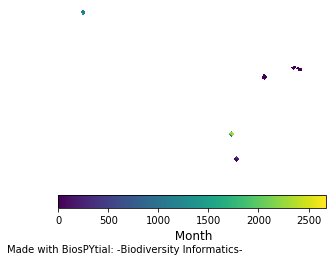

In [39]:
mammals.associatedData.raster_Elevation.display_field()

## Display with Geoviews
We will use this package to add interactivity and zooming events.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
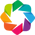

In [111]:
import geoviews as gv
from cartopy import crs
from geoviews import opts
gv.extension('bokeh')
opts.defaults(
    opts.Image(width=600, height=400, colorbar=True))
xmam = mammals.associatedData.raster_Elevation.to_xarray()

In [122]:
subset = xmam.where(((xmam.Longitude > -92.9) & (xmam.Longitude < -92.4) & 
                     (xmam.Latitude > 16.5) & (xmam.Latitude < 17)),drop=True)
subset.name = xmam.name
gvds = gv.Dataset(subset,crs=crs.PlateCarree())
images = gvds.to(gv.Image,['Longitude','Latitude']).opts(cmap=plt.cm.terrain)

In [123]:
images

:Image   [Longitude,Latitude]   (Elevation)

# Graph analytics

## Convert the TreeNeo object to a Network instance (networkx)
### The depth_level restricts the depth of the recursion process.

In [124]:
gt = big_tree.toNetworkx(depth_level=7)

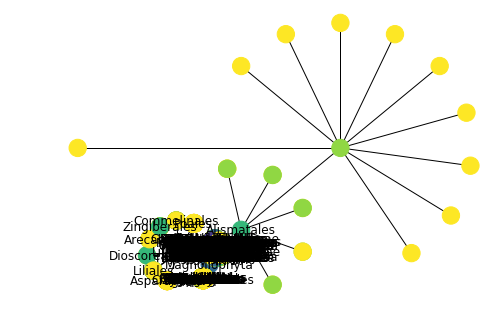

In [126]:
## Plot the Tree
from drivers.tools import plotTree
x = plotTree(big_tree)

## Standard Graph analysis
With the **networkx** library

In [127]:
import networkx as nt
lap =nt.laplacian_matrix(gt)

In [128]:
sp = nt.laplacian_spectrum(gt)

In [129]:
sp.shape

(8038,)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
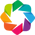

In [130]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

In [131]:
from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(gt,prog='twopi',args='')


In [132]:
graphvis = hv.Graph.from_networkx(gt,pos).opts(tools=['hover'],
                                                         width=1000,
                                                         height= 1000,)

In [133]:
nnodes = list(graphvis.nodes.data['index'])

In [134]:
names = map(lambda n : n.name, nnodes)

In [135]:

graphvis.nodes.data['name'] = names
labels = hv.Labels(graphvis.nodes,['x','y'],'name')

In [136]:
graphvis# * labels

:Graph   [start,end]

In [ ]:
z.name

## Distance to species

In [ ]:
from drivers.graph_models import Root

In [ ]:
ss = big_tree.species[0]

In [ ]:
species = map(lambda l : l.node , list(big_tree.species))

In [ ]:
pairs = [(a,b) for a in species for b in species]

In [ ]:
## Taxonomic distance doesn't use information of the graph restricted to the location. 
##Only to the taxonomic structure
dist = lambda (a,b) : a.taxonomicDistanceTo(b)

In [ ]:
%time distancias = map(dist,pairs)

In [ ]:
distancias = np.array(distancias).reshape(len(genera),len(genera))


In [ ]:
plt.imshow(distancias,cmap=plt.cm.Reds)
plt.colorbar()

I need to replace the root node because is treeneo and it should be localtree
After this we will have the shortestpath with attribute n_presences list guaja guaajajajajaj!!!

In [ ]:
lynx = lambda (a,b) : a.mergeLinageWithNode(b)

In [ ]:
%time linages = map(lynx,pairs)

## Here we will use the general graph to extract shortest paths and attributes. 
The attributes extracted are related to the geographical context and therefore they are defined in the LocalTree class which extends the TreeNode class (is a super class of LocalTree).
When the graph is built 'gt' 

In [ ]:
## With the graph object
pathsf = lambda (a,b) : nt.shortest_path(gt,a,b)
%time paths = map(pathsf,pairs)

In [ ]:
paths[1] == linages[1]

In [ ]:
nt.draw(linages[1])

In [ ]:
ppp1 = nt.shortest_path(linages[1],pairs[1][0],pairs[1][1])

In [ ]:
ppp1 == paths[1]

In [ ]:
paths[1]

In [ ]:
freqs = nt.get_node_attributes(gt,'freq')
richness = nt.get_node_attributes(gt,'richness')
level  = nt.get_node_attributes(gt,'level')




In [ ]:
def modifiedDistance(path):
    extractFreqsFromPath = lambda path : map(lambda node : freqs[node],path)
    extractRichnessFromPath = lambda path : map(lambda node : richness[node],path)
    extractLevelFromPath = lambda path : map(lambda node : level[node],path)
    dat = pd.DataFrame({'freq' : extractFreqsFromPath(path),'rich':extractRichnessFromPath(path),'level':extractLevelFromPath(path)})
    dat['level'] = dat.level + 1
    dat['fl'] = dat.freq / dat.level
    
    return dat.sum()

In [ ]:
test1 = modifiedDistance(pp1)

In [ ]:
%time distances_m = map(lambda path : modifiedDistance(path),paths)

In [ ]:
distances_m = pd.DataFrame(distances_m)

In [ ]:
n = len(species)

In [ ]:
plt.imshow(distances_m.freq.values.reshape(n,n))
plt.colorbar()

In [ ]:
plt.imshow(distances_m.rich.values.reshape(n,n))

In [ ]:
plt.imshow(distances_m.level.values.reshape(n,n))

In [ ]:
plt.imshow(distances_m.fl.values.reshape(n,n))

In [ ]:
map(lambda n : freqs[n],pp1)

In [ ]:
p0.__dict__

In [ ]:
nn1 = big_t.species[0]

In [ ]:
l1.edges()

In [ ]:
from drivers.tree_builder import LocalTree

In [ ]:
type(big_t.node)

In [ ]:
isinstance(big_t.node,TreeNeo)

In [ ]:
ed1 = gt.edges()[0]

In [ ]:
nt.Graph.add_edge?

In [ ]:
nt.Graph().add_edge

In [ ]:
dist2 = lambda (a,b) : nt.shortest_path_length(gt,a,b,weight='freq')

In [ ]:
%time distancias = map(dist2,pairs)

In [ ]:
distancias = np.array(distancias).reshape(len(genera),len(genera))

In [ ]:
plt.imshow(distancias,cmap=plt.cm.Reds)
plt.colorbar()

In [ ]:
nodes = gt.nodes()

In [ ]:
from drivers.graph_models import TreeNode
root = filter(lambda a : not isinstance(a,TreeNode),nodes).pop()

In [ ]:
gt.remove_node(root)

In [ ]:
nt.get_edge_attributes(gt,name='freq')

In [ ]:
type(big_t.node.node)

In [ ]:
distancias = np.array(distancias).reshape(len(genera),len(genera))
plt.imshow(distancias)
plt.colorbar()

In [ ]:
g.node.ta

In [ ]:
g = genera[0]
dist = []
for node in genera:
    print("calculating distance")
    %time dist.append(node.mergeLinageWithNode(g))
    
#cosas = map(lambda n : g.taxonomicDistanceTo(n),genera)

In [ ]:
distances = []
for specie in big_t.species:
    distances.append(map(lambda sp : specie.node.taxonomicDistanceTo(sp.node),big_t.species))
    

In [ ]:
import pandas as pd
sp_dist_table = pd.DataFrame(distances)


In [ ]:
### Export to R
x = table.to_json()
from drivers.tools import redisConnection as rc
r = rc()
r.set('spatstats2017',x)
r.keys()